# Modelo Not BIO 32-lstm-dropout0.3-dense-adam-sigmoid

In [1]:
MODELO = "lstm32_dropout0.3_dense_rmsprop"
LABELS = ["NADA",
          "B-CENTRO", "I-CENTRO", "B-CONTACTO", "B-DIRECCION", "I-DIRECCION", "B-HISTORIA", 
          "B-IDENT", "I-IDENT", "B-PERSONA", "I-PERSONA", "B-REFERENCIA", "B-UBICACION", "I-UBICACION"]

LABELS_VAL = ["NADA", "B-CENTRO", "I-CENTRO", "B-CONTACTO", "B-DIRECCION", "I-DIRECCION", "B-HISTORIA", 
              "B-IDENT", "B-PERSONA", "I-PERSONA", "B-REFERENCIA", "B-UBICACION", "I-UBICACION"]

model = "bio-noda-bilstm"

## Imports

In [2]:
import os
import json
import logging
import argparse
import pandas as pd
import numpy as np
import seaborn as sbn

from pathlib import Path
from sklearn import metrics
from IPython.display import display
from matplotlib import pyplot as plt

from galennlp_keras_utils.sequences import (
    GeneratorConf,
    multilabel,
)

In [3]:
# Avoid printing warnings.
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow
from tensorflow.keras import models as k_models
from tensorflow.keras import layers as k_layers
from tensorflow.keras import metrics as k_metrics
from keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint as latest_checkpoint
from tensorflow.keras.callbacks import CSVLogger

print(tensorflow.__version__)

if tensorflow.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else:
    print("The installed version of TensorFlow does not include GPU support.")

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

2.10.0-dev20220404
The installed version of TensorFlow includes GPU support.
Num GPUs Available:  1


## Random seeds

In [4]:
import random

seed = 12345

tensorflow.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Workspace Directions

In [5]:
# Workspace.
workspace_dir = os.path.abspath('') + '\\'
print(workspace_dir)

# Results.
results_dir = workspace_dir + 'results_guille-bio\\' + model + '\\'
Path(results_dir).mkdir(exist_ok=True)
print(results_dir)

# Data.
data_dir = 'C:\\Galen\\galen_guille\\bio-bin\\'
Path(data_dir).mkdir(exist_ok=True)
print(data_dir)

# Model.
model_dir = workspace_dir + 'models_galen\\' + model + '\\'
Path(model_dir).mkdir(exist_ok=True)
print(model_dir)

D:\Galen\deidentificacion\
D:\Galen\deidentificacion\results_guille-bio\bio-noda-bilstm\
C:\Galen\galen_guille\bio-bin\
D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\


## Etiquetas

In [6]:
with open(data_dir +'etiquetas-bio.txt', 'r') as file:
    print (file.read())

O
B-CENTRO
I-CENTRO
B-CONTACTO
B-DIRECCION
I-DIRECCION
B-HISTORIA
B-IDENT
I-IDENT
B-PERSONA
I-PERSONA
B-REFERENCIA
B-UBICACION
I-UBICACION



## Construir Modelo

In [7]:
def build_model(n_features, n_classes, mask_value):
    "build keras model"
    model = k_models.Sequential([
        k_layers.Masking(mask_value=mask_value, input_shape=(None, n_features)),
        k_layers.Bidirectional(k_layers.LSTM(32, dropout=0.3, return_sequences=True)),
        k_layers.TimeDistributed(k_layers.Dense(16, activation="relu")),
        k_layers.TimeDistributed(k_layers.Dense(n_classes, activation="sigmoid"))
    ])
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=[
            k_metrics.CategoricalAccuracy(),
            k_metrics.AUC(curve="PR", name="auc_pr"),
            k_metrics.Precision(),
            k_metrics.Recall()
        ]
    )
    display(model.summary())
    return model

## Configuración Entrenamiento

In [8]:
args_train = [
    Path(data_dir + 'train.npy'),
]
args_valid = [
    Path(data_dir + 'val.npy')
]
args_test = [
    Path(data_dir + 'test.npy')
]

args_conf = Path(model_dir + 'conf_galen.json')
with open(args_conf) as fd_conf:
    settings = json.load(fd_conf)

eval_settings = settings.get("eval", {})
    
mask_value = settings['generator']['mask_value']
batch_size = settings['generator']['batch_size']
epochs = settings['generator']['epochs']

ref_metric = eval_settings.get("metric", "f1_samples")
patience = eval_settings.get("early_stop", None)
threshold = eval_settings.get("threshold", 0.5)

print("CONFIG:")
print("epochs:", str(epochs))
print("batch_size:", str(batch_size))
print("mask_value:", str(mask_value))
print("onehot:", str(settings['generator']['onehot']))
print("is_weighted:", str(settings['generator']['is_weighted']))
print("metric:", str(ref_metric))
print("early_stop:", str(patience))
print("threshold:", str(threshold))

classes = settings['data']['classes']
null_class = None #settings['data']['null_class']

print()
print("DATA:")
print("classes:", len(classes))
print("null class:", null_class)
print("tags:")
for idx, tag in enumerate(classes):
    print("%d: %s" % (idx, tag))

CONFIG:
epochs: 500
batch_size: 64
mask_value: -99
onehot: True
is_weighted: True
metric: f1_macro
early_stop: 75
threshold: 0.5

DATA:
classes: 14
null class: None
tags:
0: O
1: B-CENTRO
2: I-CENTRO
3: B-CONTACTO
4: B-DIRECCION
5: I-DIRECCION
6: B-HISTORIA
7: B-IDENT
8: I-IDENT
9: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Función de Evaluación

In [9]:
def evaluar_red(network, testgen, null_class, threshold=0.5):
    """evaluar la red con el generador de test proporcionado

    network - keras model
    testgen - dataset iterator
    null_class - índice de la clase nula (o None)
    """
    prediccion = testgen.predict(network)
    # print(prediccion.shape)
    p_prob = prediccion[:, 0, :]
    p_pred = (p_prob > threshold) + 0.0
    p_true = prediccion[:, 1, :]
    valid_labels = list(range(p_true.shape[-1]))
    if null_class is not None:
        valid_labels = [x for x in valid_labels if x != null_class]
    m_micro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="micro",
        zero_division=0
    )
    m_macro = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="macro",
        zero_division=0
    )
    m_samples = metrics.precision_recall_fscore_support(
        p_true,
        p_pred,
        labels=valid_labels,
        average="samples",
        zero_division=0
    )
    out = {
        #"roc_auc_macro": metrics.roc_auc_score(p_true, p_prob, average="macro"),
        #"roc_auc_micro": metrics.roc_auc_score(p_true, p_prob, average="micro"),
        "pr_auc_macro": metrics.average_precision_score(p_true, p_prob, average="macro"),
        "pr_auc_micro": metrics.average_precision_score(p_true, p_prob, average="micro"),
        "f1_micro": m_micro[2],
        "f1_macro": m_macro[2],
        "f1_samples": m_samples[2],
        "precision_micro": m_micro[0],
        "precision_macro": m_macro[0],
        "precision_samples": m_samples[0],
        "recall_micro": m_micro[1],
        "recall_macro": m_macro[1],
        "recall_samples": m_samples[1],
    }
    return out, prediccion

## Crear generadores de datos

In [10]:
gen_conf = GeneratorConf(**settings["generator"])
display(gen_conf)

gen_train = multilabel.MultiLabelTrainSequence(args_train, gen_conf)
gen_valid = multilabel.MultiLabelTrainSequence(args_valid, gen_conf)
gen_test = multilabel.MultiLabelTrainSequence(args_test, gen_conf)

features = gen_train.manifest().input_segment.size()
classes = gen_train.manifest().output_segment.size()

print()
print("Pesos de clases")
display(gen_train.pseudo_class_weights)

print()
print("FEATURES:", features)
print("CLASSES:", classes)
print("TAGS:")
for idx, tag in sorted(gen_train.manifest().tags.items()):
    print("%02d: %s" % (idx, tag))

GeneratorConf(batch_size=64, epochs=500, onehot=True, exclusive_onehot=False, is_weighted=True, mask_value=-99, classes=None, null_class=None, flatten=False)


Pesos de clases


{0: 0.07184551314938423,
 1: 98.70268620268621,
 2: 27.188262002858824,
 3: 1074.252491694352,
 4: 23096.428571428572,
 5: 4199.350649350649,
 6: 2566.2698412698414,
 7: 733.219954648526,
 8: 1443.5267857142858,
 9: 105.70447858777378,
 10: 206.21811224489795,
 11: 334.7308488612836,
 12: 135.4629241726016,
 13: 166.76121712222795}


FEATURES: 416
CLASSES: 14
TAGS:
00: O
01: B-CENTRO
02: I-CENTRO
03: B-CONTACTO
04: B-DIRECCION
05: I-DIRECCION
06: B-HISTORIA
07: B-IDENT
08: I-IDENT
09: B-PERSONA
10: I-PERSONA
11: B-REFERENCIA
12: B-UBICACION
13: I-UBICACION


## Crear Modelo

In [11]:
red = build_model(features, classes, mask_value=mask_value)

checkpoint_path = model_dir + 'model_checkpoint.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,
                              monitor="val_recall",
                              mode="max",
                              verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 416)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         114944    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 16)         1040      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 14)         238       
 tributed)                                                       
                                                                 
Total params: 116,222
Trainable params: 116,222
Non-trainable params: 0
__________________________________________________

None

## Entrenar Modelo

In [12]:
def train():
    # save tags
    with open(results_dir + 'etiquetas.txt', 'wt') as fd_lbl:
        for _, tag in sorted(gen_train.manifest().tags.items()):
            print(tag, file=fd_lbl)
            
    history = {}
    metricas = []
    best_idx = 0
    best_ref_value = -1
    best_prediction = None
    for idx in range(epochs):
        if patience is not None:
            print(f"epoch {idx} / {epochs} (patience {idx - best_idx} / {patience})")
        else:
            print(f"epoch {idx} / {epochs}")
            
        ep_history = red.fit(
            gen_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=gen_valid,
            callbacks=[cp_callback],
            verbose=1
        )
        red.save(str(results_dir + 'final_model.h5'))
        
        for k, v in ep_history.history.items():
            if k not in history:
                history[k] = []
            history[k].extend(v)

        # evaluación de medidas para todo el conjunto de validacion
        # para evitar promedio por batch
        values, prediction = evaluar_red(red, gen_valid, null_class, threshold)
        ref_value = values[ref_metric]
        if ref_value > best_ref_value:
            best_ref_value = ref_value
            best_idx = idx
            best_prediction = prediction
            print('Mejor valor ', ref_metric, best_ref_value)
            red.save(str(results_dir + 'best_model.h5'))

        prediction = None
        metricas.append(values)
        
        if idx and (patience is not None) and ((idx - best_idx) > patience):
            print(f"Paciencia agotada tras {patience} épocas")
            break

    print('Mejor %s de validación en epoch %d' % (ref_metric, best_idx))

    history = pd.DataFrame(history)
    metricas = pd.DataFrame(metricas)

    np.save(str(results_dir + 'best_prediction.npy'), best_prediction)
    history.to_csv(results_dir + 'history.csv')
    metricas.to_csv(results_dir + 'metricas.csv')
    np.save(str(results_dir + 'best_idx.npy'), best_idx)
    
train()

epoch 0 / 500 (patience 0 / 75)
324/324 [==============================] - ETA: 0s - loss: 0.0433 - categorical_accuracy: 0.0682 - auc_pr: 0.0603 - precision: 0.0028 - recall: 3.9610e-04
Epoch 1: val_recall improved from -inf to 0.00012, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\model_checkpoint.ckpt
324/324 [==============================] - 27s 60ms/step - loss: 0.0433 - categorical_accuracy: 0.0682 - auc_pr: 0.0603 - precision: 0.0028 - recall: 3.9610e-04 - val_loss: 0.0280 - val_categorical_accuracy: 0.8830 - val_auc_pr: 0.8525 - val_precision: 1.0000 - val_recall: 1.1770e-04
Mejor valor  f1_macro 0.05195744970236458
epoch 1 / 500 (patience 1 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0320 - categorical_accuracy: 0.8778 - auc_pr: 0.8779 - precision: 0.9983 - recall: 0.1825
Epoch 1: val_recall improved from 0.00012 to 0.52737, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\model_checkpoint.ckpt
324/324 [===

Mejor valor  f1_macro 0.40040881468444584
epoch 14 / 500 (patience 1 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0110 - categorical_accuracy: 0.9781 - auc_pr: 0.9948 - precision: 0.9825 - recall: 0.9660
Epoch 1: val_recall did not improve from 0.98110
324/324 [==============================] - 16s 49ms/step - loss: 0.0109 - categorical_accuracy: 0.9782 - auc_pr: 0.9948 - precision: 0.9825 - recall: 0.9660 - val_loss: 0.0120 - val_categorical_accuracy: 0.9797 - val_auc_pr: 0.9943 - val_precision: 0.9853 - val_recall: 0.9669
epoch 15 / 500 (patience 2 / 75)
324/324 [==============================] - ETA: 0s - loss: 0.0107 - categorical_accuracy: 0.9803 - auc_pr: 0.9954 - precision: 0.9848 - recall: 0.9686
Epoch 1: val_recall improved from 0.98110 to 0.98140, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\model_checkpoint.ckpt
324/324 [==============================] - 16s 50ms/step - loss: 0.0107 - categorical_accuracy: 0.9803 - auc_pr: 0.99

epoch 29 / 500 (patience 3 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0064 - categorical_accuracy: 0.9923 - auc_pr: 0.9978 - precision: 0.9935 - recall: 0.9885
Epoch 1: val_recall improved from 0.98879 to 0.99269, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\model_checkpoint.ckpt
324/324 [==============================] - 17s 53ms/step - loss: 0.0064 - categorical_accuracy: 0.9923 - auc_pr: 0.9978 - precision: 0.9935 - recall: 0.9885 - val_loss: 0.0138 - val_categorical_accuracy: 0.9945 - val_auc_pr: 0.9981 - val_precision: 0.9953 - val_recall: 0.9927
Mejor valor  f1_macro 0.5141736203815961
epoch 30 / 500 (patience 1 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0066 - categorical_accuracy: 0.9927 - auc_pr: 0.9979 - precision: 0.9938 - recall: 0.9890
Epoch 1: val_recall did not improve from 0.99269
324/324 [==============================] - 16s 49ms/step - loss: 0.0066 - categorical_accuracy: 0.9927 - auc_pr: 0.997

Mejor valor  f1_macro 0.6441652223556346
epoch 44 / 500 (patience 1 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0044 - categorical_accuracy: 0.9962 - auc_pr: 0.9986 - precision: 0.9969 - recall: 0.9939
Epoch 1: val_recall did not improve from 0.99527
324/324 [==============================] - 16s 49ms/step - loss: 0.0044 - categorical_accuracy: 0.9962 - auc_pr: 0.9985 - precision: 0.9969 - recall: 0.9939 - val_loss: 0.0131 - val_categorical_accuracy: 0.9951 - val_auc_pr: 0.9977 - val_precision: 0.9964 - val_recall: 0.9916
epoch 45 / 500 (patience 2 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0044 - categorical_accuracy: 0.9958 - auc_pr: 0.9984 - precision: 0.9967 - recall: 0.9930
Epoch 1: val_recall did not improve from 0.99527
324/324 [==============================] - 16s 49ms/step - loss: 0.0044 - categorical_accuracy: 0.9958 - auc_pr: 0.9984 - precision: 0.9967 - recall: 0.9931 - val_loss: 0.0139 - val_categorical_accuracy: 0.9967 - val

323/324 [============================>.] - ETA: 0s - loss: 0.0026 - categorical_accuracy: 0.9977 - auc_pr: 0.9989 - precision: 0.9981 - recall: 0.9961
Epoch 1: val_recall did not improve from 0.99693
324/324 [==============================] - 16s 49ms/step - loss: 0.0026 - categorical_accuracy: 0.9977 - auc_pr: 0.9989 - precision: 0.9981 - recall: 0.9961 - val_loss: 0.0149 - val_categorical_accuracy: 0.9967 - val_auc_pr: 0.9980 - val_precision: 0.9973 - val_recall: 0.9944
epoch 60 / 500 (patience 2 / 75)
323/324 [============================>.] - ETA: 0s - loss: 0.0025 - categorical_accuracy: 0.9976 - auc_pr: 0.9989 - precision: 0.9980 - recall: 0.9960
Epoch 1: val_recall did not improve from 0.99693
324/324 [==============================] - 16s 49ms/step - loss: 0.0025 - categorical_accuracy: 0.9976 - auc_pr: 0.9989 - precision: 0.9980 - recall: 0.9960 - val_loss: 0.0185 - val_categorical_accuracy: 0.9978 - val_auc_pr: 0.9986 - val_precision: 0.9982 - val_recall: 0.9965
epoch 61 / 50

324/324 [==============================] - ETA: 0s - loss: 4.8255e-04 - categorical_accuracy: 0.9989 - auc_pr: 0.9994 - precision: 0.9992 - recall: 0.9982
Epoch 1: val_recall did not improve from 0.99821
324/324 [==============================] - 16s 49ms/step - loss: 4.8255e-04 - categorical_accuracy: 0.9989 - auc_pr: 0.9994 - precision: 0.9992 - recall: 0.9982 - val_loss: 0.0197 - val_categorical_accuracy: 0.9985 - val_auc_pr: 0.9988 - val_precision: 0.9988 - val_recall: 0.9975
epoch 90 / 500 (patience 5 / 75)
324/324 [==============================] - ETA: 0s - loss: 2.4448e-04 - categorical_accuracy: 0.9991 - auc_pr: 0.9995 - precision: 0.9993 - recall: 0.9985
Epoch 1: val_recall did not improve from 0.99821
324/324 [==============================] - 16s 49ms/step - loss: 2.4448e-04 - categorical_accuracy: 0.9991 - auc_pr: 0.9995 - precision: 0.9993 - recall: 0.9985 - val_loss: 0.0172 - val_categorical_accuracy: 0.9985 - val_auc_pr: 0.9989 - val_precision: 0.9987 - val_recall: 0.99

epoch 105 / 500 (patience 20 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.5590e-04 - categorical_accuracy: 0.9991 - auc_pr: 0.9995 - precision: 0.9993 - recall: 0.9984
Epoch 1: val_recall did not improve from 0.99831
324/324 [==============================] - 16s 50ms/step - loss: 1.5544e-04 - categorical_accuracy: 0.9991 - auc_pr: 0.9995 - precision: 0.9993 - recall: 0.9984 - val_loss: 0.0147 - val_categorical_accuracy: 0.9984 - val_auc_pr: 0.9988 - val_precision: 0.9988 - val_recall: 0.9977
epoch 106 / 500 (patience 21 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.6619e-04 - categorical_accuracy: 0.9993 - auc_pr: 0.9996 - precision: 0.9994 - recall: 0.9987
Epoch 1: val_recall did not improve from 0.99831
324/324 [==============================] - 16s 49ms/step - loss: 1.6582e-04 - categorical_accuracy: 0.9993 - auc_pr: 0.9996 - precision: 0.9994 - recall: 0.9987 - val_loss: 0.0154 - val_categorical_accuracy: 0.9986 - val_auc_pr: 0.9989 - val

323/324 [============================>.] - ETA: 0s - loss: 1.2122e-04 - categorical_accuracy: 0.9995 - auc_pr: 0.9997 - precision: 0.9996 - recall: 0.9992
Epoch 1: val_recall did not improve from 0.99871
324/324 [==============================] - 16s 49ms/step - loss: 1.2087e-04 - categorical_accuracy: 0.9995 - auc_pr: 0.9997 - precision: 0.9996 - recall: 0.9992 - val_loss: 0.0162 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9991 - val_precision: 0.9992 - val_recall: 0.9986
Mejor valor  f1_macro 0.7804270318670784
epoch 136 / 500 (patience 1 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.7456e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9992
Epoch 1: val_recall improved from 0.99871 to 0.99876, saving model to D:\Galen\deidentificacion\models_galen\bio-noda-bilstm\model_checkpoint.ckpt
324/324 [==============================] - 16s 50ms/step - loss: 1.7403e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9997 - precision: 0

324/324 [==============================] - 16s 49ms/step - loss: 1.0260e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9993 - val_loss: 0.0171 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9990 - val_precision: 0.9991 - val_recall: 0.9986
epoch 151 / 500 (patience 16 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.0298e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99882
324/324 [==============================] - 16s 49ms/step - loss: 1.0266e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0165 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9990 - val_precision: 0.9991 - val_recall: 0.9987
epoch 152 / 500 (patience 17 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.5880e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9994
Epoch 1: 

epoch 166 / 500 (patience 10 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.0163e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9993
Epoch 1: val_recall did not improve from 0.99884
324/324 [==============================] - 16s 49ms/step - loss: 1.0163e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9993 - val_loss: 0.0168 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9989 - val_precision: 0.9991 - val_recall: 0.9986
epoch 167 / 500 (patience 11 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.2162e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9993
Epoch 1: val_recall did not improve from 0.99884
324/324 [==============================] - 16s 49ms/step - loss: 1.2162e-04 - categorical_accuracy: 0.9996 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9993 - val_loss: 0.0167 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9989 - val

epoch 182 / 500 (patience 26 / 75)
323/324 [============================>.] - ETA: 0s - loss: 8.5368e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99884
324/324 [==============================] - 16s 49ms/step - loss: 8.5156e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0216 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9989 - val_precision: 0.9991 - val_recall: 0.9987
epoch 183 / 500 (patience 27 / 75)
324/324 [==============================] - ETA: 0s - loss: 3.6261e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9994
Epoch 1: val_recall did not improve from 0.99884
324/324 [==============================] - 16s 50ms/step - loss: 3.6261e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9994 - val_loss: 0.0185 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9989 - val

epoch 198 / 500 (patience 42 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.7131e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9994
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 49ms/step - loss: 1.7078e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9997 - precision: 0.9997 - recall: 0.9994 - val_loss: 0.0197 - val_categorical_accuracy: 0.9988 - val_auc_pr: 0.9988 - val_precision: 0.9990 - val_recall: 0.9986
epoch 199 / 500 (patience 43 / 75)
323/324 [============================>.] - ETA: 0s - loss: 9.4259e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 49ms/step - loss: 9.3992e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0195 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9988 - val

epoch 214 / 500 (patience 58 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.0452e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9994
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 49ms/step - loss: 1.0452e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9997 - recall: 0.9994 - val_loss: 0.0199 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9989 - val_precision: 0.9992 - val_recall: 0.9987
epoch 215 / 500 (patience 59 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.0090e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 49ms/step - loss: 1.0090e-04 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0204 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

epoch 230 / 500 (patience 11 / 75)
323/324 [============================>.] - ETA: 0s - loss: 9.8654e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 50ms/step - loss: 9.8350e-05 - categorical_accuracy: 0.9997 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0222 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val_precision: 0.9991 - val_recall: 0.9988
epoch 231 / 500 (patience 12 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.1996e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99886
324/324 [==============================] - 16s 51ms/step - loss: 1.1959e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0205 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

epoch 246 / 500 (patience 27 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.4135e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9999 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 1.4091e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9999 - recall: 0.9996 - val_loss: 0.0201 - val_categorical_accuracy: 0.9989 - val_auc_pr: 0.9987 - val_precision: 0.9991 - val_recall: 0.9987
epoch 247 / 500 (patience 28 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.5194e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 1.5147e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996 - val_loss: 0.0202 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

epoch 262 / 500 (patience 43 / 75)
324/324 [==============================] - ETA: 0s - loss: 1.0456e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 1.0456e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0206 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val_precision: 0.9991 - val_recall: 0.9988
epoch 263 / 500 (patience 44 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.5122e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 1.5075e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996 - val_loss: 0.0211 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

epoch 278 / 500 (patience 59 / 75)
323/324 [============================>.] - ETA: 0s - loss: 9.7575e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 9.7275e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996 - val_loss: 0.0205 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val_precision: 0.9992 - val_recall: 0.9989
epoch 279 / 500 (patience 60 / 75)
323/324 [============================>.] - ETA: 0s - loss: 1.4964e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 49ms/step - loss: 1.4919e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9998 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0211 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

epoch 294 / 500 (patience 75 / 75)
323/324 [============================>.] - ETA: 0s - loss: 4.0584e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 4.0460e-04 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9999 - recall: 0.9996 - val_loss: 0.0222 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9989 - val_precision: 0.9991 - val_recall: 0.9989
epoch 295 / 500 (patience 76 / 75)
323/324 [============================>.] - ETA: 0s - loss: 9.5931e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9996
Epoch 1: val_recall did not improve from 0.99893
324/324 [==============================] - 16s 50ms/step - loss: 9.5643e-05 - categorical_accuracy: 0.9998 - auc_pr: 0.9999 - precision: 0.9998 - recall: 0.9996 - val_loss: 0.0206 - val_categorical_accuracy: 0.9990 - val_auc_pr: 0.9988 - val

## Mostrar history

,Unnamed: 0,loss,categorical_accuracy,auc_pr,precision,recall,val_loss,val_categorical_accuracy,val_auc_pr,val_precision,val_recall
0,0,0.043294,0.068169,0.060325,0.002834,0.000396,0.027967,0.883013,0.852463,1.000000,0.000118
1,1,0.031987,0.877727,0.877815,0.998267,0.182558,0.022167,0.936658,0.942272,0.997625,0.527372
2,2,0.029079,0.887146,0.910965,0.973061,0.538693,0.019553,0.854661,0.881203,0.972530,0.497260
3,3,0.025911,0.927859,0.950376,0.973028,0.745396,0.016982,0.951155,0.970142,0.979009,0.860016
4,4,0.024173,0.945724,0.970493,0.972183,0.846057,0.015367,0.946584,0.970394,0.976263,0.849829
...,...,...,...,...,...,...,...,...,...,...,...
291,291,0.003869,0.999781,0.999806,0.999828,0.999605,0.020234,0.999026,0.998845,0.999182,0.998882
292,292,0.000115,0.999842,0.999870,0.999846,0.999730,0.021158,0.998960,0.998727,0.999071,0.998764
293,293,0.000327,0.999815,0.999846,0.999845,0.999601,0.021319,0.999006,0.998834,0.999117,0.998849
294,294,0.000405,0.999829,0.999864,0.999851,0.999649,0.022183,0.999019,0.998865,0.999150,0.998901


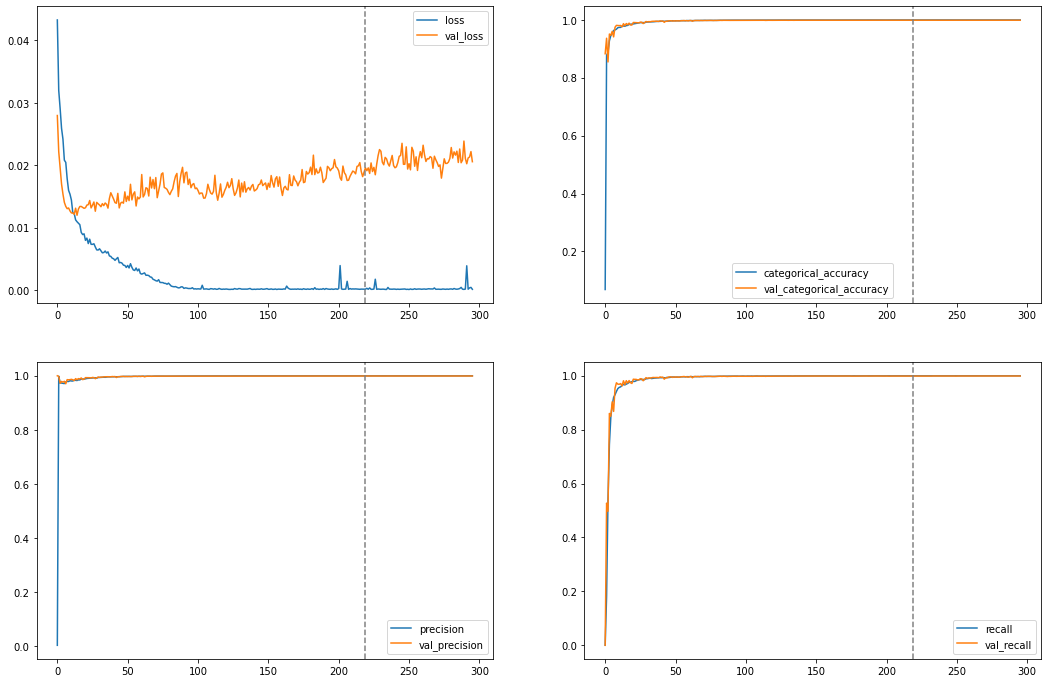

In [13]:
history = pd.read_csv(results_dir + 'history.csv')
best_idx = np.load(results_dir + 'best_idx.npy')

fig, axes = plt.subplots(2, 2, figsize=(18,12))
display(history)
history[["loss", "val_loss"]].plot(ax=axes[0,0]).axvline(x=best_idx, color='gray', linestyle='--')
history[["categorical_accuracy", "val_categorical_accuracy"]].plot(ax=axes[0,1]).axvline(x=best_idx, color='gray', linestyle='--')
history[["precision", "val_precision"]].plot(ax=axes[1,0]).axvline(x=best_idx, color='gray', linestyle='--')
history[["recall", "val_recall"]].plot(ax=axes[1,1]).axvline(x=best_idx, color='gray', linestyle='--')
plt.show()

## Mostrar metricas

,Unnamed: 0,pr_auc_macro,pr_auc_micro,f1_micro,f1_macro,f1_samples,precision_micro,precision_macro,precision_samples,recall_micro,recall_macro,recall_samples
0,0,0.191103,0.852563,0.000235,0.051957,0.000118,1.000000,0.142857,0.000118,0.000118,0.040821,0.000118
1,1,0.326987,0.942344,0.689994,0.182379,0.527369,0.997625,0.214954,0.527368,0.527372,0.211294,0.527372
2,2,0.352627,0.881278,0.658019,0.192794,0.496399,0.972504,0.225627,0.495985,0.497228,0.270415,0.497228
3,3,0.408236,0.970154,0.915663,0.254990,0.857695,0.979009,0.381089,0.856534,0.860016,0.408033,0.860016
4,4,0.395647,0.970555,0.908709,0.321100,0.847298,0.976330,0.329899,0.846023,0.849848,0.474227,0.849848
...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,0.801405,0.999738,0.999032,0.759908,0.998849,0.999182,0.804576,0.998833,0.998882,0.730687,0.998882
292,292,0.800649,0.999784,0.998918,0.763598,0.998729,0.999071,0.794585,0.998712,0.998764,0.746647,0.998764
293,293,0.805827,0.999778,0.998983,0.762049,0.998823,0.999117,0.796809,0.998810,0.998849,0.740664,0.998849
294,294,0.804837,0.999711,0.999026,0.777698,0.998860,0.999150,0.804850,0.998839,0.998901,0.755486,0.998901


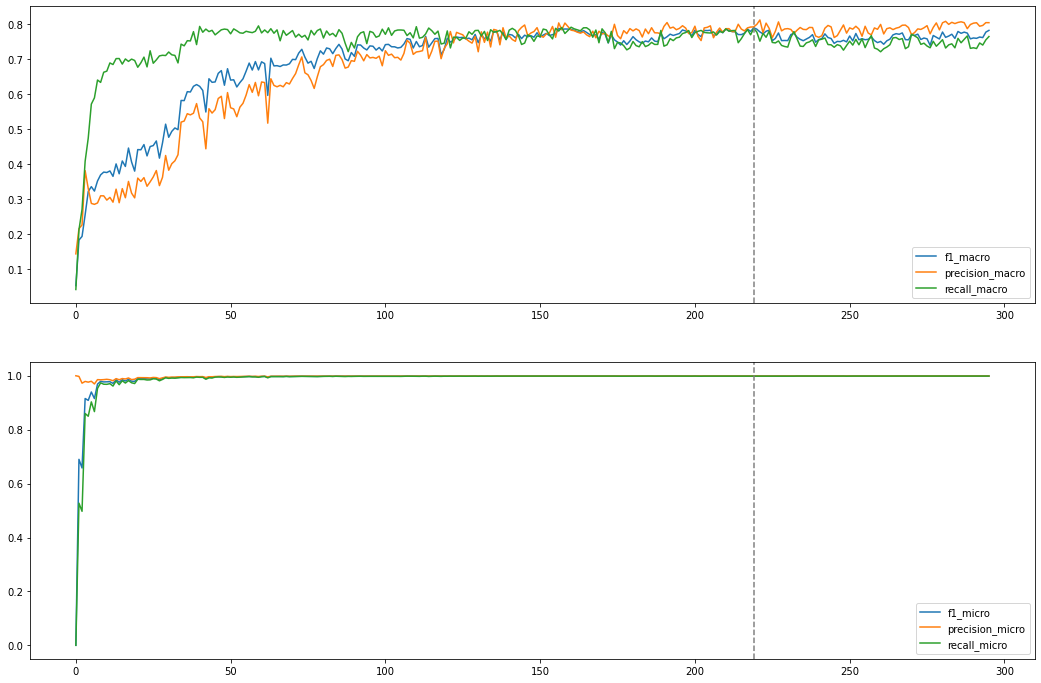

In [14]:
metricas = pd.read_csv(results_dir + 'metricas.csv')

fig, axes = plt.subplots(2, 1, figsize=(18,12))
display(metricas)
metricas[["f1_macro", "precision_macro", "recall_macro"]].plot(ax=axes[0]).axvline(x=best_idx, color="gray", linestyle="--")
metricas[["f1_micro", "precision_micro", "recall_micro"]].plot(ax=axes[1]).axvline(x=best_idx, color="gray", linestyle="--")

## Mostrar best_prediction

<AxesSubplot:>

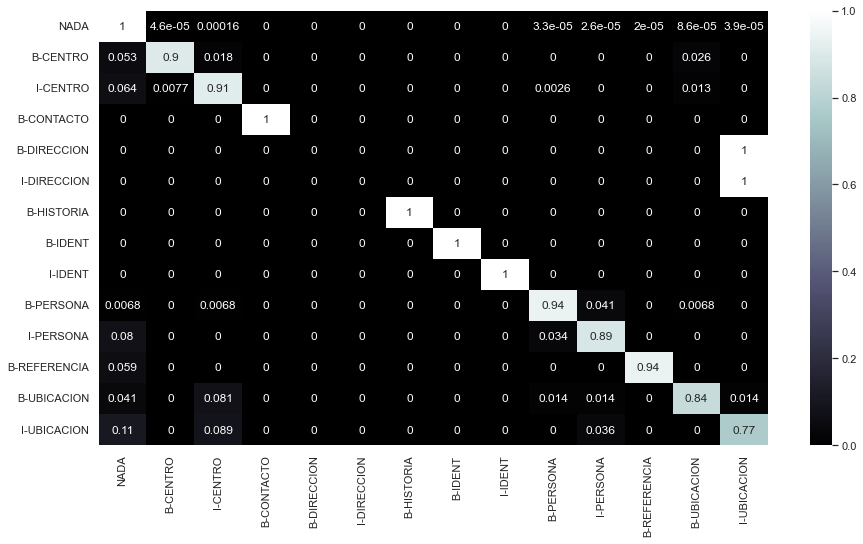

In [16]:
prediction = np.load(results_dir + 'best_prediction.npy')
best_prediction_true = np.zeros(shape=[prediction.shape[0]])
best_prediction_pred = np.zeros(shape=[prediction.shape[0]])

for i in range(prediction.shape[0]):
    best_prediction_pred[i,] = np.argmax(prediction[i,0,])
    best_prediction_true[i,] = np.argmax(prediction[i,1,])
    
sbn.set(rc = {'figure.figsize':(15,8)})

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

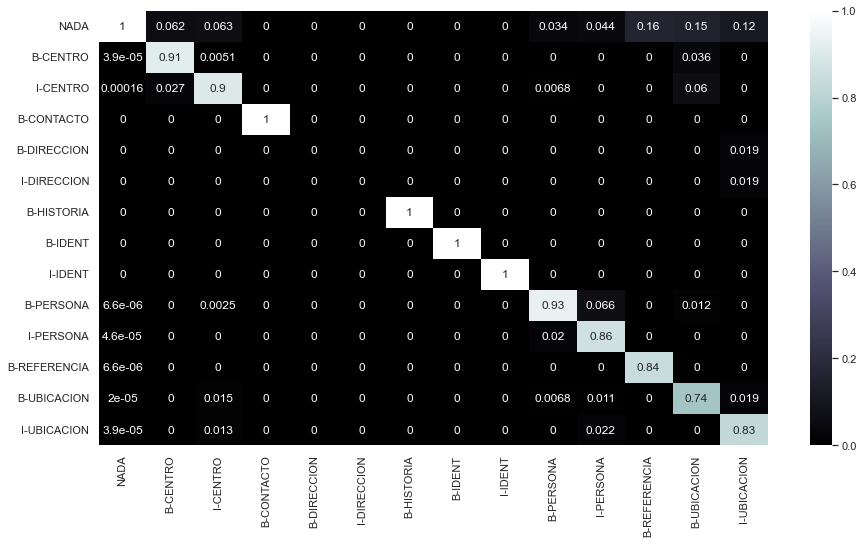

In [17]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

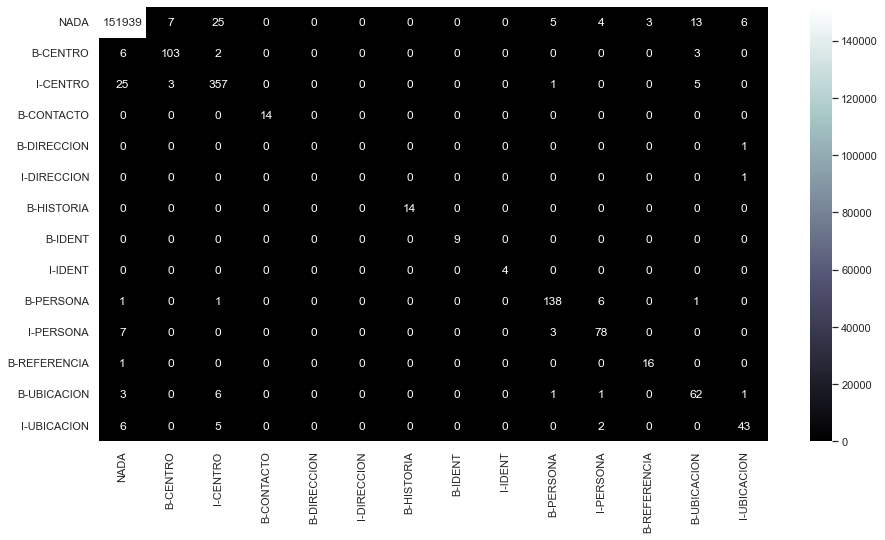

In [18]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(best_prediction_true, best_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar validación

In [19]:
# Ocultar warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

print(metrics.classification_report(best_prediction_true, best_prediction_pred, target_names=LABELS))

              precision    recall  f1-score   support

        NADA       1.00      1.00      1.00    152002
    B-CENTRO       0.91      0.90      0.91       114
    I-CENTRO       0.90      0.91      0.91       391
  B-CONTACTO       1.00      1.00      1.00        14
 B-DIRECCION       0.00      0.00      0.00         1
 I-DIRECCION       0.00      0.00      0.00         1
  B-HISTORIA       1.00      1.00      1.00        14
     B-IDENT       1.00      1.00      1.00         9
     I-IDENT       1.00      1.00      1.00         4
   B-PERSONA       0.93      0.94      0.94       147
   I-PERSONA       0.86      0.89      0.87        88
B-REFERENCIA       0.84      0.94      0.89        17
 B-UBICACION       0.74      0.84      0.78        74
 I-UBICACION       0.83      0.77      0.80        56

    accuracy                           1.00    152932
   macro avg       0.79      0.80      0.79    152932
weighted avg       1.00      1.00      1.00    152932



## Cargar modelo

In [20]:
# Crear una nueva instancia del modelo
model = tensorflow.keras.models.load_model(str(results_dir + 'best_model.h5'))

# Re-evaluar el modelo para todo el conjunto de test
values, prediction = evaluar_red(model, gen_test, None, threshold)
test_prediction = prediction
np.save(str(results_dir + 'test_prediction.npy'), test_prediction)

## Mostrar test_prediction

<AxesSubplot:>

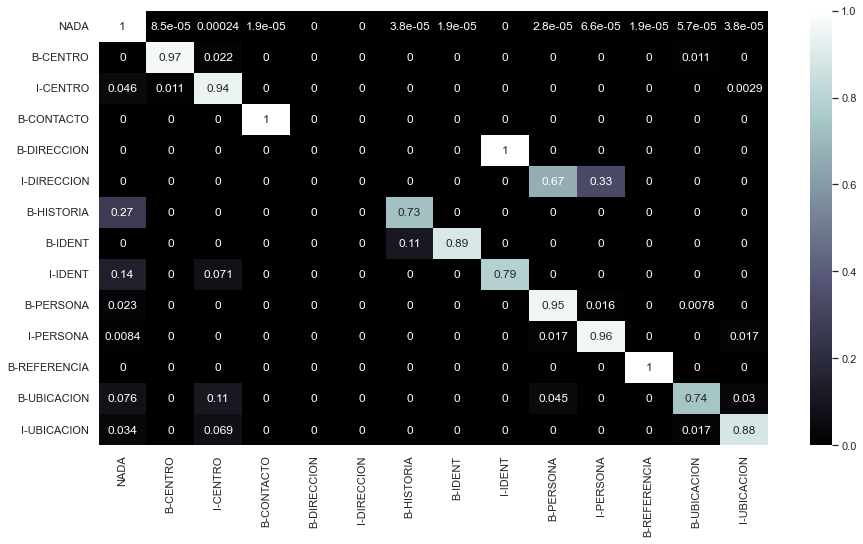

In [21]:
test_prediction = np.load(results_dir + 'test_prediction.npy')
test_prediction_true = np.zeros(shape=[test_prediction.shape[0]])
test_prediction_pred = np.zeros(shape=[test_prediction.shape[0]])

for i in range(test_prediction.shape[0]):
    test_prediction_pred[i,] = np.argmax(test_prediction[i,0,])
    test_prediction_true[i,] = np.argmax(test_prediction[i,1,])

sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="true"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

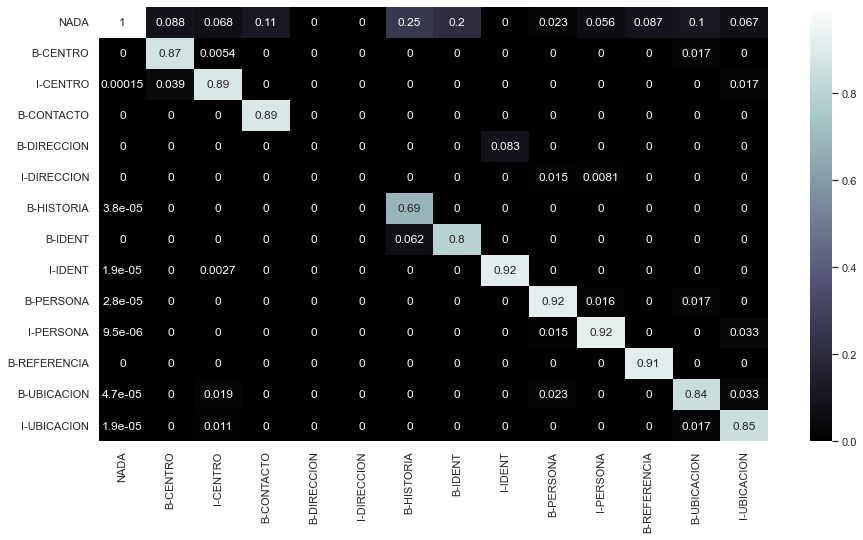

In [22]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred, normalize="pred"), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
)

<AxesSubplot:>

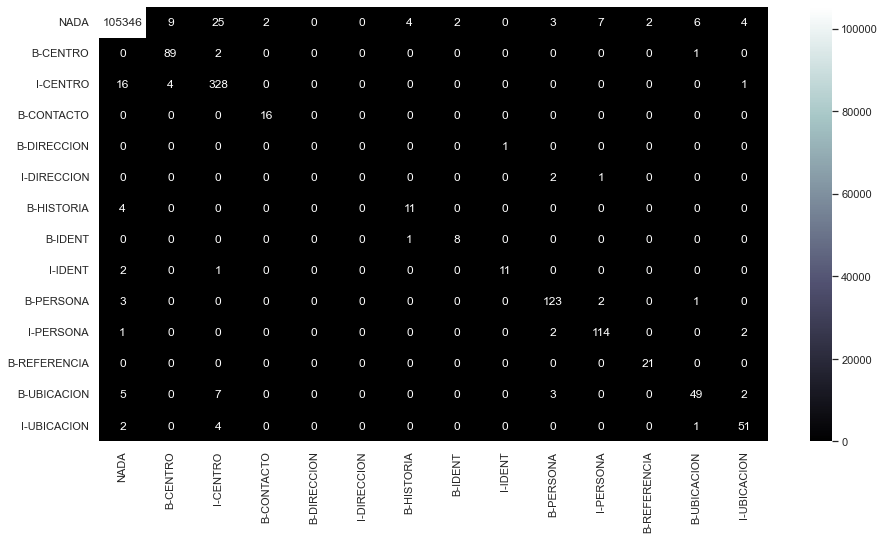

In [23]:
sbn.heatmap(
    pd.DataFrame(metrics.confusion_matrix(test_prediction_true, test_prediction_pred), index=list(LABELS), columns=list(LABELS)),
    annot=True,
    cmap="bone",
    fmt="d"
)

## Evaluar test 

In [24]:
print(metrics.classification_report(test_prediction_true, test_prediction_pred, target_names=LABELS))

              precision    recall  f1-score   support

        NADA       1.00      1.00      1.00    105410
    B-CENTRO       0.87      0.97      0.92        92
    I-CENTRO       0.89      0.94      0.92       349
  B-CONTACTO       0.89      1.00      0.94        16
 B-DIRECCION       0.00      0.00      0.00         1
 I-DIRECCION       0.00      0.00      0.00         3
  B-HISTORIA       0.69      0.73      0.71        15
     B-IDENT       0.80      0.89      0.84         9
     I-IDENT       0.92      0.79      0.85        14
   B-PERSONA       0.92      0.95      0.94       129
   I-PERSONA       0.92      0.96      0.94       119
B-REFERENCIA       0.91      1.00      0.95        21
 B-UBICACION       0.84      0.74      0.79        66
 I-UBICACION       0.85      0.88      0.86        58

    accuracy                           1.00    106302
   macro avg       0.75      0.77      0.76    106302
weighted avg       1.00      1.00      1.00    106302

